# Finite-element simulations of JAX elastoplasticity

In this example, we show how to use an elastoplastic `JAXMaterial` within a `FEniCSx` finite-element simulation. We use a von Mises elastoplastic material with a general isotropic hardening model. The JAX implementation of such a behavior is described in [](/jax_elastoplasticity.md#generic-elastoplasticity-with-isotropic-hardening).

```{image} /images/elastoplasticity.gif
:align: center
:width: 700px
```

We start by loading the relevant modules. In particular, we will make use of the `QuadratureMap` object available in `dolfinx_materials.quadrature_map` which handles the exchange of information between `FEniCSx` and custom material objects, here a `JAXMaterial`. In this demo, we configure `jax` to run on the CPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax

jax.config.update("jax_platform_name", "cpu")
from mpi4py import MPI
import ufl
from dolfinx import io, fem
from dolfinx.common import timing, list_timings
from dolfinx_materials.material import JAXMaterial
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.solvers import NonlinearMaterialProblem

import jaxmat.materials as jm
from generate_mesh import generate_perforated_plate

## Material definition

We first define our elastoplastic behavior using the `vonMisesIsotropicHardening` class which represents a `jaxmat` von Mises elastoplastic material which takes as input arguments a `jaxmat` `LinearElasticIsotropic` material and a nonlinear hardening yield stress function, here we use a Voce-type exponential harding (`VoceHardening`) such that:

$$
\sigma_Y(p) = \sigma_0 + (\sigma_u-\sigma_0)\exp(-bp)
$$
where $\sigma_0$ and $\sigma_u$ are the initial and final yield stresses respectively and $b$ is a hardening parameter controlling the rate of convergence from $\sigma_0$ to $\sigma_u$ as a function of the cumulated plastic strain $p$.

Finally, the resulting `jaxmat` behavior is converted to a `dolfinx`-compatible material via the `JAXMaterial` class.

In [2]:
E, nu = 70e3, 0.3


sig0 = 350.0
sigu = 500.0
b = 1e3

elasticity = jm.LinearElasticIsotropic(E=E, nu=nu)

hardening = jm.VoceHardening(sig0=sig0, sigu=sigu, b=b)

behavior = jm.vonMisesIsotropicHardening(elasticity=elasticity, yield_stress=hardening)

material = JAXMaterial(behavior)

## Problem setup

We then generate the mesh of a rectangular plate of dimensions $L_x\times L_y$ perforated by a circular hole of radius R at its center using `gmsh`. `mesh_sizes=(fine_size, coarse_size)` enables to locally refine the mesh size near the hole. The bottom and top faces of the plate are tagged `1` and `2` respectively.

In [3]:
Lx = 1.0
Ly = 2.0
R = 0.2
mesh_sizes = (0.008, 0.2)
mesh_data = generate_perforated_plate(Lx, Ly, R, mesh_sizes)
cell_markers = mesh_data.cell_tags
facets = mesh_data.facet_tags
domain = mesh_data.mesh

ds = ufl.Measure("ds", subdomain_data=facets)

We define the function space for the displacement $\boldsymbol{u}$, interpolated here with quadratic Lagrange elements. We apply prescribed Dirichlet boundary conditions on the bottom and top dofs. For the constitutive equation, we use a quadrature degree equal to twice the degree of the associated strain i.e. `2*(order-1)=2` here.

In [4]:
order = 2
deg_quad = 2 * (order - 1)
shape = (2,)

V = fem.functionspace(domain, ("P", order, shape))
bottom_dofs = fem.locate_dofs_topological(V, 1, facets.find(1))
top_dofs = fem.locate_dofs_topological(V, 1, facets.find(2))

uD_b = fem.Function(V)
uD_t = fem.Function(V)
bcs = [fem.dirichletbc(uD_t, top_dofs), fem.dirichletbc(uD_b, bottom_dofs)]

Now, we define the `QuadratureMap` object associated with the elastoplastic `material`. We check that the material has only one gradient field, here the field `"strain"` and one flux field, here the field `"stress"`. We register the UFL object `strain(u)` corresponding to the vectorial Mandel representation of the strain components.

In [5]:
def strain(u):
    return ufl.as_vector(
        [
            u[0].dx(0),
            u[1].dx(1),
            0.0,
            1 / np.sqrt(2) * (u[1].dx(0) + u[0].dx(1)),
            0.0,
            0.0,
        ]
    )


u = fem.Function(V, name="Displacement")

qmap = QuadratureMap(domain, deg_quad, material)
print("Gradients", material.gradient_names)
print("Fluxes", material.flux_names)
qmap.register_gradient(material.gradient_names[0], strain(u))
qmap.update()

Gradients ['strain']
Fluxes ['stress']


We can then use the abstract flux field `"stress"` to define the weak formulation in small strain conditions and use `qmap.derivative` to define the associated tangent form using AutoDiff.

In [6]:
du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

sig = qmap.fluxes["stress"]
Res = ufl.dot(sig, strain(v)) * qmap.dx
Jac = qmap.derivative(Res, u, du)

Next, the custom nonlinear problem is defined with the class `NonlinearMaterialProblem` as well as the corresponding Newton solver.

In [7]:
petsc_options = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "none",
    "snes_atol": 1e-6,
    "snes_rtol": 1e-6,
    "snes_monitor": None,
    "log_view": None,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
problem = NonlinearMaterialProblem(
    qmap,
    Res,
    u,
    bcs=bcs,
    J=Jac,
    petsc_options_prefix="elastoplasticity",
    petsc_options=petsc_options,
)

We then loop over a set of imposed vertical strains, apply the corresponding imposed displacement boundary condition on the top surface, solve the problem and then compute plastic and stress fields projected onto a DG space for visualization. Finally, we use the imposed displacement field to compute the associated resultant force in a consistent manner, see [](https://bleyerj.github.io/comet-fenicsx/tips/computing_reactions/computing_reactions.html) for more details.

In [8]:
out_file = "results/elastoplasticity.pvd"
vtk = io.VTKFile(domain.comm, out_file, "w")

N = 15
Eyy = np.linspace(0, 10e-3, N + 1)
Force = np.zeros_like(Eyy)
nit = np.zeros_like(Eyy)
for i, eyy in enumerate(Eyy[1:]):
    u_imp = eyy * Ly
    uD_t.x.array[1::2] = u_imp

    problem.solve()

    converged = problem.solver.getConvergedReason()
    num_iter = problem.solver.getIterationNumber()
    assert converged > 0, f"Solver did not converge, got {converged}."
    print(
        f"Increment {i} converged after {num_iter} iterations with converged reason {converged}."
    )

    p = qmap.project_on("p", ("DG", 0))
    stress = qmap.project_on("stress", ("DG", 0))

    Force[i + 1] = fem.assemble_scalar(fem.form(ufl.action(Res, u))) / u_imp

    syy = stress.sub(1).collapse()
    syy.name = "stress"
    vtk.write_function(u, i + 1)
    vtk.write_function(p, i + 1)
    vtk.write_function(syy, i + 1)
    nit[i + 1] = num_iter

vtk.close()

  0 SNES Function norm 6.256767237341e+02
  1 SNES Function norm 7.828668281551e-12
Increment 0 converged after 1 iterations with converged reason 2.
  0 SNES Function norm 6.256767237341e+02
  1 SNES Function norm 9.682672308540e-12
Increment 1 converged after 1 iterations with converged reason 2.
  0 SNES Function norm 6.256767237341e+02
  1 SNES Function norm 3.689257682610e-01
  2 SNES Function norm 6.250317014398e-03
  3 SNES Function norm 8.041303521773e-07
Increment 2 converged after 3 iterations with converged reason 2.
  0 SNES Function norm 6.256767237341e+02
  1 SNES Function norm 8.271869053925e-01
  2 SNES Function norm 3.608662939652e-02
  3 SNES Function norm 4.102832377543e-05
Increment 3 converged after 3 iterations with converged reason 3.
  0 SNES Function norm 6.256767237341e+02
  1 SNES Function norm 8.741013038306e-01
  2 SNES Function norm 5.026111858416e-02
  3 SNES Function norm 3.145528133549e-04
Increment 4 converged after 3 iterations with converged reason 3

## Results

We plot the evolution of the apparent vertical stress as a function of the imposed apparent strain. We observe a progressive onset of plasticity after a first elastic phase. The apparent stress then saturates, reaching a perfectly plastic plateau associated with plastic collapse of the plate.

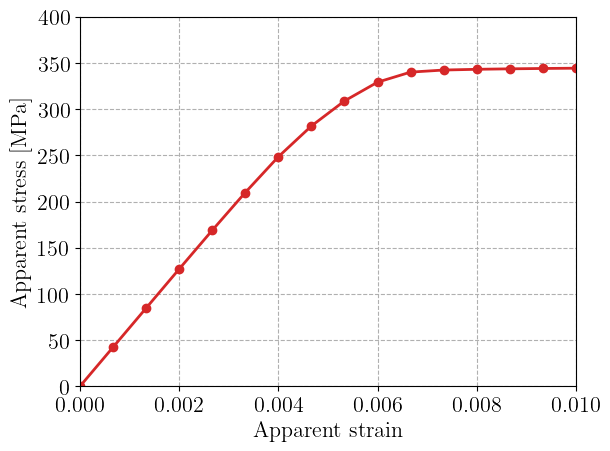

In [9]:
plt.plot(Eyy, Force / Lx, "-oC3")
plt.xlabel("Apparent strain")
plt.ylabel("Apparent stress [MPa]")
plt.ylim(0, 400)
plt.show()

We report below the evolution of the number of Newton iterations for each load step. We can see that in the first iterations, convergence is reached in 1 iteration only, corresponding to the elastic stage. The number of iterations then increases during the plastic stage.

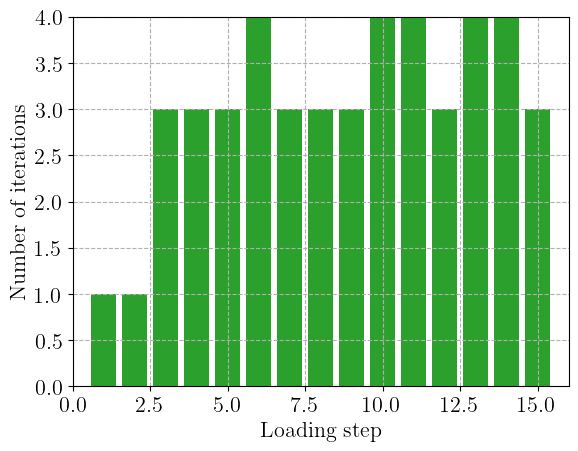

In [10]:
plt.bar(np.arange(N + 1), nit, color="C2")
plt.xlabel("Loading step")
plt.ylabel("Number of iterations")
plt.xlim(0, N + 1)
plt.show()

We measure below the time spent in the full SNES solve and the time spent only in the constitutive integration part. We can check that the latter represents only a small fraction of the total computing time which is mostly dominated by the cost of solving the global linear system at each global Newton iteration.

In [11]:
snes_solve = timing("SNES: solve")[1].total_seconds()
print(f"Total solving time {snes_solve:.2f}s")
constitutive_update_time = timing("SNES: constitutive update")[1].total_seconds()
print(f"Total time spent in constitutive update {constitutive_update_time:.2f}s")

Total solving time 21.17s
Total time spent in constitutive update 5.99s


We can list below the breakdown of the different timings.

In [12]:
list_timings(MPI.COMM_WORLD)


[MPI_MAX] Summary of timings (s)                                            |  reps       avg        tot
--------------------------------------------------------------------------------------------------------
Build dofmap data                                                           |    38  0.000645   0.024508
Compute connectivity 1-0                                                    |     1  0.000068   0.000068
Compute connectivity 2-0                                                    |     1  0.000127   0.000127
Compute dof reordering map                                                  |    38  0.000079   0.003017
Compute entities of dim = 1                                                 |     1  0.003479   0.003479
Compute local part of mesh dual graph (mixed)                               |     1  0.006964   0.006964
Compute local-to-local map                                                  |     1  0.000579   0.000579
Compute-local-to-global links for global/local adjacen